# Simulate BLER of NumPy decoder

And compare against Sionna reference implementation.

In [1]:
import numpy as np
import sionna as sn
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import tensorflow as tf
from sionna.phy.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder

from numpy_decoder import *


/home/nvidia/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2025-03-25 20:15:53.524607: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-25 20:15:53.524681: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-25 20:15:53.526183: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been r

In [ ]:
num_bits_per_symbol = 2

constellation = sn.phy.mapping.Constellation("qam", num_bits_per_symbol)

mapper = sn.phy.mapping.Mapper(constellation=constellation)
demapper = sn.phy.mapping.Demapper("maxlog", constellation=constellation)
awgn_channel = sn.phy.channel.AWGN()
binary_source = sn.phy.mapping.BinarySource()


def decode_np(enc, llr, num_iter):
    bs = llr.shape[0]
    Zc = enc._z
    k = enc.k
    n = enc.n
    BG = 1 if enc._bg == "bg1" else 2
    num_vn = 68*Zc if BG == 1 else 52*Zc
    parity_start = 22*Zc if BG == 1 else 10*Zc
    llr_np = llr.numpy()

    llr_ch = np.clip(llr_np/32*127, -127, 127).astype(np.int8)

    llr_input = np.zeros((bs, num_vn),dtype=np.int8) # takes care of the punctured bits (initialized to 0 LLR)
    llr_input[:,2*Zc:k] =  llr_ch[:,:k-2*Zc] # unpunctured message bits
    llr_input[:,k:parity_start] = 127      # shortened bits
    llr_input[:,parity_start:parity_start+n-k+2*Zc] = llr_ch[:,k-2*Zc:] # parity bits
    uhats = np.zeros((bs, k), dtype=np.uint8)
    for i, y in enumerate(llr_input):
        u_packed,_ = decode_ldpc(BG, Zc, k, num_iter, y)
        uhats[i] = np.unpackbits(u_packed.astype(np.uint8))[:k]
    return uhats

trials = 1000
num_iter = 8

bg = 1
if bg == 2:
    k = 292
    n = k + 40*3
else:
    k = 800
    n = 1000

# Init Sionna encoder
enc = LDPC5GEncoder(k, n)
print(f"BG: {enc._bg}, Z: {enc._z}")
dec = LDPC5GDecoder(enc, hard_out=True, cn_update="minsum", num_iter=num_iter)

coderate= k/n

ebno_dbs = np.linspace(2, 8, 10)
blers_np = np.zeros_like(ebno_dbs, dtype=np.float32)
blers_sionna = np.zeros_like(ebno_dbs, dtype=np.float32)

sn.phy.config.seed = 42
u = binary_source([trials, k])

# run Monte Carlo simulation
for i, ebno_db in enumerate(ebno_dbs):
    no = sn.phy.utils.ebnodb2no(ebno_db, num_bits_per_symbol=num_bits_per_symbol,coderate=coderate)
    c = enc(u)
    x = mapper(c)
    y = awgn_channel(x, no)
    llr = -demapper(y,no) # sionna defines LLRs the wrong way around

    u_hat_sionna = dec(-llr)
    bler_sionna = sn.phy.utils.compute_bler(u, u_hat_sionna)

    # run NumPy decoder
    u_hat_np = decode_np(enc, llr, num_iter)
    bler_np = sn.phy.utils.compute_bler(u, u_hat_np)

    blers_sionna[i] = bler_sionna
    blers_np[i] = bler_np
    if bler_sionna < 1e-5 and bler_np < 1e-5:
        break


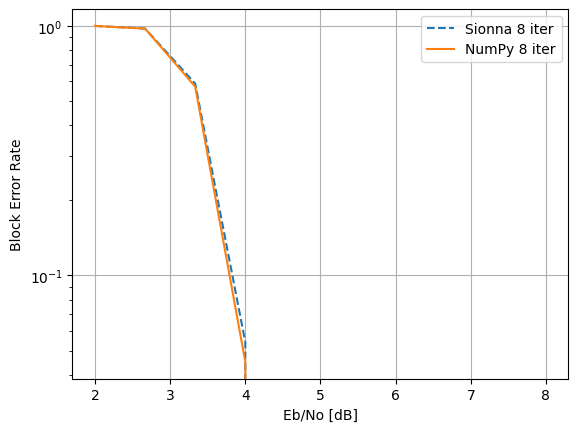

In [11]:
x1 = interp1d(blers_np, ebno_dbs, kind='linear', fill_value="extrapolate")
x2 = interp1d(blers_sionna, ebno_dbs, kind='linear', fill_value="extrapolate")
delta_snr = abs(x1(0.01).item() - x2(0.01).item())

plt.plot(ebno_dbs, blers_sionna, label=f"Sionna {num_iter} iter", linestyle='--')
plt.plot(ebno_dbs, blers_np, label=f"NumPy {num_iter} iter", linestyle='-')


plt.yscale("log")
plt.xlabel("Eb/No [dB]")
plt.ylabel("Block Error Rate")
plt.legend()
plt.grid()
plt.show()